# Tensorflow Setup and Utility Functions

This notebook provides essential functions for setting up a Tensorflow Environment, loading and preprocessing image datasets, and visualizing the data. It's designed to be flexible and adaptable to various directory structures and image formats.

## Imports

- **tensorflow (tf)**: The main library for machine learning operations.
- **numpy (np)**: A library for numerical operations on large, multi-dimensional arrays and matrices.
- **matplotlib.pyplot (plt)**: A library for creating visualizations.
- **seaborn (sns)**: A library for creating more attractive visualizations.
- **pandas (pd)**: A library for data manipulation and analysis.
- **time**: A library for working with time and measuring performance.
- **pathlib.Path**: Provides an object-oriented interface for working with filesystem paths.
- **typing**: A library for type hints and annotations.
- **datetime**: A library for working with dates and times.
- **tqdm**: A library for creating interactive progress bars.
- **sklearn**: A library for machine learning operations.

## GPU Functions

The following functions are used to set up the Tensorflow environment and check for the presence of a GPU.


In [307]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from tqdm import tqdm
from pathlib import Path
from typing import Tuple, List, Dict, Optional
from datetime import datetime
from sklearn.manifold import TSNE

### Tensorflow Auxiliary Functinons and Configuration


In [308]:
print(f"Tensorflow version: {tf.__version__}")

Tensorflow version: 2.17.0


In [309]:
tf.keras.mixed_precision.set_global_policy("float32")

In [310]:
def setup_gpu() -> Tuple[tf.distribute.Strategy, int]:
    """
    Set up a GPU strategy for tensorflow.

    This function does the following
    1. Detects available GPUs.
    2. Sets up an appropriate strategy for the available GPUs.
    3. Returns the strategy and number of GPUs available.

    This function handles three cases:
    - No GPUs: returns a default strategy using CPU.
    - Single GPU: returns a MirroredStrategy with a single device.
    - Multiple GPUs: returns a MirroredStrategy with all available devices.

    Returns:
      tuple: (tf.distribute.Strategy, int) where the first element is the strategy and the second element is the number of GPUs available.
    """

    gpus = tf.config.list_physical_devices("GPU")
    num_gpus = len(gpus)

    if num_gpus == 0:
        print(f"No GPUs detected. Running on CPU.")
        return tf.distribute.get_strategy(), 0

    elif num_gpus == 1:
        print(f"1 GPU detected: {gpus[0].name}")
        return tf.distribute.MirroredStrategy(), 1

    else:
        print(f"{num_gpus} GPUs detected: {[gpu.name for gpu in gpus]}")
        return tf.distribute.MirroredStrategy(), num_gpus

In [311]:
def setup_tensorboard():
    """
    Setup a TensorBoard for visualization. To view the TensorBoard, run the following command in the terminal:

    tensorboard --logdir logs/scalars
    """

    logdir = "logs/scalars" + datetime.now().strftime("%Y%m%d-%H%M%S")
    file_writer = tf.summary.create_file_writer(str(logdir + "/metrics"))
    file_writer.set_as_default()

    print(f"TensorBoard logs will be saved to: {logdir}")

In [312]:
def benchmark_data_pipeline(dataset: tf.data.Dataset):
    """
    Benchmark the data pipeline to ensure efficient data loading.

    Args:
      dataset (tf.data.Dataset): Dataset to benchmark.
    """

    start_time = time.time()
    for _ in tqdm(dataset, desc="Benchmarking data pipeline"):
        pass

    end_time = time.time()
    print(f"Data pipeline benchmark: {end_time - start_time:.2f} seconds")

### Auxiliary Functions


In [313]:
def load_dataset(
    data_path,
    img_size: Tuple[int, int] = (224, 224),
    batch_size: int = 32,
    validation_split: float = 0.2,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, List[str]]:
    """
    Load and preprocess data using tf.data API.

    Args:
      data_path (str): Path to the data directory.
      img_size (tuple): Image size to resize to.
      batch_size (int): Batch size.
      validation_split (float): Fraction of data to use for validation.

    Returns:
      tuple: (tf.data.Dataset, tf.data.Dataset) where the first element is the training dataset and the second element is the validation dataset.
    """

    data_dir = Path(data_path)
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=validation_split,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
    )

    class_names = train_ds.class_names

    # Performance optimization
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, class_names

In [314]:
def load_best_model(model_path: str) -> tf.keras.Model:
    """
    Load the best model from a given path.

    Args:
      model_path (str): Path to the model directory.

    Returns:
      tf.keras.Model: Model loaded from the given path.
    """

    best_model_path = Path(model_path) / "checkpoints" / "best_model.keras"
    return tf.keras.models.load_model(str(best_model_path))

## Data Augmentation


In [315]:
import albumentations as A

In [316]:
class DataAugmentation(tf.keras.layers.Layer):
    def __init__(self, img_size: Tuple[int, int] = (224, 224)):
        super().__init__()
        self.img_size = img_size
        self.transform = A.Compose(
            [
                # Light enhancement techniques
                A.OneOf(
                    [
                        A.RandomBrightnessContrast(
                            brightness_limit=(0.2, 0.4),
                            contrast_limit=(0.2, 0.4),
                            p=0.8,
                        ),
                        A.CLAHE(clip_limit=6.0, tile_grid_size=(8, 8), p=0.8),
                    ],
                    p=1.0,
                ),
                # Noise handling
                A.OneOf(
                    [
                        A.ISONoise(
                            color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.7
                        ),
                        A.GaussNoise(var_limit=(10.0, 50.0), mean=0, p=0.3),
                    ],
                    p=0.8,
                ),
                # Gamma correction
                A.RandomGamma(gamma_limit=(70, 130), p=0.7),
                # Blur and sharpness
                A.OneOf(
                    [
                        A.MedianBlur(blur_limit=3, p=0.3),
                        A.GaussianBlur(blur_limit=3, p=0.3),
                        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.4),
                    ],
                    p=0.5,
                ),
                # Color adjustments
                A.OneOf(
                    [
                        A.HueSaturationValue(
                            hue_shift_limit=5,
                            sat_shift_limit=10,
                            val_shift_limit=15,
                            p=0.5,
                        ),
                        A.RGBShift(
                            r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5
                        ),
                    ],
                    p=0.3,
                ),
            ]
        )

    def _augment_single_image(self, image):
        """Augment a single image."""
        if isinstance(image, tf.Tensor):
            image = image.numpy()

        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        augmented = self.transform(image=image)["image"]
        return augmented.astype(np.float32) / 255.0

    @tf.function
    def call(self, images, training=True):
        if not training:
            return images

        # Ensure images are in float32 format
        images = tf.cast(images, tf.float32)
        if tf.reduce_max(images) > 1.0:
            images = images / 255.0

        augmented = tf.map_fn(
            lambda x: tf.py_function(self._augment_single_image, [x], tf.float32),
            images,
            dtype=tf.float32,
        )

        # Ensure the shape is maintained
        augmented.set_shape(images.shape)
        return augmented

### Visualization Functions


In [317]:
def visualize_data_augmentation(
    dataset: tf.data.Dataset,
    data_augmentation: tf.keras.layers.Layer,
    num_images: int = 3,
    num_augmentations: int = 4,
    figsize: Tuple[int, int] = None,
    save_path: Optional[str] = None,
):
    """
    Visualizes multiple augmentations of images from the dataset.

    Args:
        dataset: TensorFlow dataset containing images
        data_augmentation: Augmentation layer
        num_images: Number of original images to show
        num_augmentations: Number of augmentations per image
        figsize: Optional figure size
        save_path: Optional path to save the visualization
    """
    if figsize is None:
        figsize = (4 * (num_augmentations + 1), 4 * num_images)

    fig = plt.figure(figsize=figsize)

    # Take a batch of images from the dataset
    for images, _ in dataset.take(1):
        for idx in range(min(num_images, len(images))):
            original_image = images[idx].numpy().astype("uint8")

            # Plot original image
            plt.subplot(
                num_images, num_augmentations + 1, idx * (num_augmentations + 1) + 1
            )
            plt.imshow(original_image)
            plt.title(f"Original {idx + 1}", pad=10)
            plt.axis("off")

            # Generate and plot augmentations
            for aug_idx in range(num_augmentations):
                # Apply augmentation
                augmented = data_augmentation(
                    tf.expand_dims(original_image, 0), training=True
                )

                # Convert augmented image for display
                augmented_image = augmented[0].numpy()
                if augmented_image.max() <= 1.0:
                    augmented_image = (augmented_image * 255).astype(np.uint8)

                # Plot augmented image
                plt.subplot(
                    num_images,
                    num_augmentations + 1,
                    idx * (num_augmentations + 1) + aug_idx + 2,
                )
                plt.imshow(augmented_image)
                plt.title(f"Augmented {aug_idx + 1}", pad=10)
                plt.axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"Visualization saved to: {save_path}")

    plt.show()


def visualize_augmentation_comparison(
    dataset: tf.data.Dataset,
    data_augmentation: tf.keras.layers.Layer,
    num_pairs: int = 4,
    figsize: Tuple[int, int] = (12, 3),
    save_path: Optional[str] = None,
):
    """
    Visualizes before/after pairs of augmented images in a single row.

    Args:
        dataset: TensorFlow dataset containing images
        data_augmentation: Augmentation layer
        num_pairs: Number of before/after pairs to show
        figsize: Figure size
        save_path: Optional path to save the visualization
    """
    plt.figure(figsize=figsize)

    for images, _ in dataset.take(1):
        for idx in range(min(num_pairs, len(images))):
            # Original image
            plt.subplot(2, num_pairs, idx + 1)
            original_image = images[idx].numpy().astype("uint8")
            plt.imshow(original_image)
            plt.title("Original")
            plt.axis("off")

            # Augmented image
            plt.subplot(2, num_pairs, num_pairs + idx + 1)
            augmented = data_augmentation(
                tf.expand_dims(original_image, 0), training=True
            )
            augmented_image = augmented[0].numpy()
            if augmented_image.max() <= 1.0:
                augmented_image = (augmented_image * 255).astype(np.uint8)
            plt.imshow(augmented_image)
            plt.title("Augmented")
            plt.axis("off")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"Visualization saved to: {save_path}")

    plt.show()

In [318]:
def show_batch(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Display a batch of images from the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to display.
        class_names (list): List of class names.
    """

    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)

            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

In [319]:
def analyze_class_distribution(dataset: tf.data.Dataset, class_names: List[str]):
    """
    Analyze and visualize the class distribution in the dataset.

    Args:
        dataset (tf.data.Dataset): Dataset to analyze.
        class_names (list): List of class names.
    """

    class_counts = {name: 0 for name in class_names}
    for _, labels in tqdm(dataset, desc="Analyzing class distribution"):
        for label in labels:
            class_counts[class_names[label]] += 1

    df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["count"])
    df = df.sort_values("count", ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=df.index, y=df["count"], data=df)

    plt.title("Class distribution in the dataset")
    plt.xlabel("Class names")
    plt.ylabel("Count")

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [320]:
def visualize_features(
    dataset: tf.data.Dataset, class_names: List[str], num_samples: int = 1000
):
    """
    Visualize high-dimensional features using t-SNE.

    Args:
        dataset (tf.data.Dataset): Dataset to extract features from.
        class_names (list): List of class names.
        num_samples (int): Number of samples to visualize.
    """

    feature_model = tf.keras.applications.MobileNetV2(include_top=False, pooling="avg")

    features, labels = [], []

    for images, batch_labels in tqdm(
        dataset.take(num_samples // 32), desc="Extracting features"
    ):
        batch_features = feature_model(images)
        features.extend(batch_features.numpy())
        labels.extend(batch_labels.numpy())

    features = np.array(features)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        x=features_2d[:, 0],
        y=features_2d[:, 1],
        hue=labels,
        palette="tab10",
        legend="full",
        alpha=0.8,
    )

    plt.title("t-SNE visualization of high-dimensional features")
    plt.tight_layout()
    plt.show()

In [321]:
def visualize_model_architecture(model: tf.keras.Model, name: str = "base_model"):
    """
    Visualize the architecture of the model

    Args:
      model: Model to visualize
      name: Name of the model
    """

    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=True,
        show_layer_names=False,
    )

    print("Model architecture visualization saved to base_model_architecture.png")

In [343]:
def visualize_training_history(
    history,
    figsize: Tuple[int, int] = (15, 5),
    save_path: str = None,
    include_lr: bool = True,
):
    """
    Visualizes the training history of a model.

    Args:
        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
        include_lr: Whether to include learning rate plot
    """
    metrics = len(history.history.keys())
    if include_lr and "lr" in history.history:
        n_plots = 3
    else:
        n_plots = 2

    fig = plt.figure(figsize=figsize)

    # Plot accuracy
    plt.subplot(1, n_plots, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    # Add horizontal grid lines
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot loss
    plt.subplot(1, n_plots, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available
    if include_lr and "lr" in history.history:
        plt.subplot(1, n_plots, 3)
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.grid(True, linestyle="--", alpha=0.7)
        # Use log scale for learning rate
        plt.yscale("log")

    plt.tight_layout()

    # Add summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Total Epochs: {len(history.history['loss'])}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()


def visualize_detailed_history(
    history, figsize: Tuple[int, int] = (15, 10), save_path: str = None
):
    """
    Creates a detailed visualization of the training history with additional metrics.

    Args:
        history: History object returned by model.fit()
        figsize: Figure size for the plot
        save_path: If provided, saves the plot to this path
    """
    fig = plt.figure(figsize=figsize)

    # Plot main metrics
    plt.subplot(2, 2, 1)
    plt.plot(history.history["accuracy"], label="Training")
    plt.plot(history.history["val_accuracy"], label="Validation")
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.subplot(2, 2, 2)
    plt.plot(history.history["loss"], label="Training")
    plt.plot(history.history["val_loss"], label="Validation")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot accuracy and loss differences (training vs validation)
    plt.subplot(2, 2, 3)
    acc_diff = np.array(history.history["accuracy"]) - np.array(
        history.history["val_accuracy"]
    )
    plt.plot(acc_diff, label="Train-Val Difference")
    plt.title("Accuracy Difference (Training - Validation)")
    plt.xlabel("Epoch")
    plt.ylabel("Difference")
    plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)
    plt.grid(True, linestyle="--", alpha=0.7)

    # Plot learning rate if available, otherwise plot loss difference
    plt.subplot(2, 2, 4)
    if "lr" in history.history:
        plt.plot(history.history["lr"])
        plt.title("Learning Rate")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.yscale("log")
    else:
        loss_diff = np.array(history.history["loss"]) - np.array(
            history.history["val_loss"]
        )
        plt.plot(loss_diff, label="Train-Val Difference")
        plt.title("Loss Difference (Training - Validation)")
        plt.xlabel("Epoch")
        plt.ylabel("Difference")
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()

    # Print summary statistics
    best_epoch = np.argmin(history.history["val_loss"])
    best_val_loss = min(history.history["val_loss"])
    best_val_acc = max(history.history["val_accuracy"])
    final_epoch = len(history.history["loss"])

    print("\nTraining Summary:")
    print(f"Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch + 1})")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Total Epochs: {final_epoch}")

    if "lr" in history.history:
        print(f"Final Learning Rate: {history.history['lr'][-1]:.2e}")

    # Calculate overfitting metrics
    final_acc_diff = acc_diff[-1]
    max_acc_diff = np.max(acc_diff)
    print(f"\nOverfitting Metrics:")
    print(f"Final Accuracy Difference: {final_acc_diff:.4f}")
    print(f"Max Accuracy Difference: {max_acc_diff:.4f}")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=300)
        print(f"\nPlot saved to: {save_path}")

    plt.show()

## Model Creation


### Transfer Learning


In [323]:
def create_classification_model(
    img_size: Tuple[int, int],
    num_classes: int,
    weights: str = "imagenet",
    trainable_layers: int = 15,
) -> tf.keras.Model:
    """
    Creates a classification model using a pre-trained ResNet50V2 backbone.

    Args:
        img_size (tuple): Image size to resize to.
        num_classes (int): Number of classes.
        weights (str): Weights to initialize the model with.
        trainable_layers (int): Number of layers to make trainable.

    Returns:
        tf.keras.Model: Classification model.
    """

    inputs = tf.keras.layers.Input(shape=(*img_size, 3))
    augmentation_layer = DataAugmentation(img_size)

    x = augmentation_layer(inputs)
    x = tf.keras.applications.resnet_v2.preprocess_input(x * 255.0)

    base_model = tf.keras.applications.ResNet50V2(
        include_top=False,
        weights=weights,
        input_shape=(*img_size, 3),
    )

    base_model.trainable = True
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    x = base_model(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(
        256, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)

    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

In [324]:
def compile_model(model: tf.keras.Model, initial_lr: float = 5e-5):
    """
    Compiles the model with an Adam optimizer and sparse categorical crossentropy loss.

    Args:
        model (tf.keras.Model): Model to compile.
        initial_lr (float): Initial learning rate.

    Returns:
        tf.keras.Model: Compiled model.
    """

    optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

In [325]:
def create_callback(
    experiment_name: str = None, base_dir: str = "models", patience: int = 15
) -> List:
    """
    Creates model callbacks with organized directory structure and versioning.

    Args:
        experiment_name (str): Name of the experiment.
        base_dir (str): Base directory to save the model.
        patience (int): Number of epochs to wait before early stopping.

    Returns:
        list: List of callbacks.
    """

    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    if experiment_name is None:
        experiment_name = f"cattle_classification_{timestamp}"

    else:
        experiment_name = f"{experiment_name}_{timestamp}"

    model_dir = Path(base_dir) / experiment_name / "checkpoints"
    log_dir = Path(base_dir) / experiment_name / "logs"

    model_dir.mkdir(parents=True, exist_ok=True)
    log_dir.mkdir(parents=True, exist_ok=True)

    best_model_path = model_dir / "best_model.keras"
    latest_model_path = model_dir / "latest_model.keras"

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            str(best_model_path),
            save_best_only=True,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ModelCheckpoint(
            str(latest_model_path),
            save_best_only=False,
            monitor="val_accuracy",
            mode="max",
            verbose=1,
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=patience,
            min_lr=1e-7,
            mode="min",
            verbose=1,
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=str(log_dir),
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            update_freq="epoch",
            profile_batch=0,
        ),
        tf.keras.callbacks.CSVLogger(
            str(model_dir / "training.csv"),
            append=True,
        ),
    ]

    return callbacks, str(model_dir)

## Loading everything


### Hyperparameters


In [338]:
EPOCHS: int = 20
BATCH_SIZE: int = 32
IMG_SIZE: Tuple[int, int] = (224, 224)

### Loading the dataset


In [327]:
base_path = "../data/processed/labeled/"

In [328]:
train_ds, val_ds, class_names = load_dataset(base_path, IMG_SIZE, BATCH_SIZE)

Found 812 files belonging to 12 classes.
Using 650 files for training.
Found 812 files belonging to 12 classes.
Using 162 files for validation.


### Showing the data


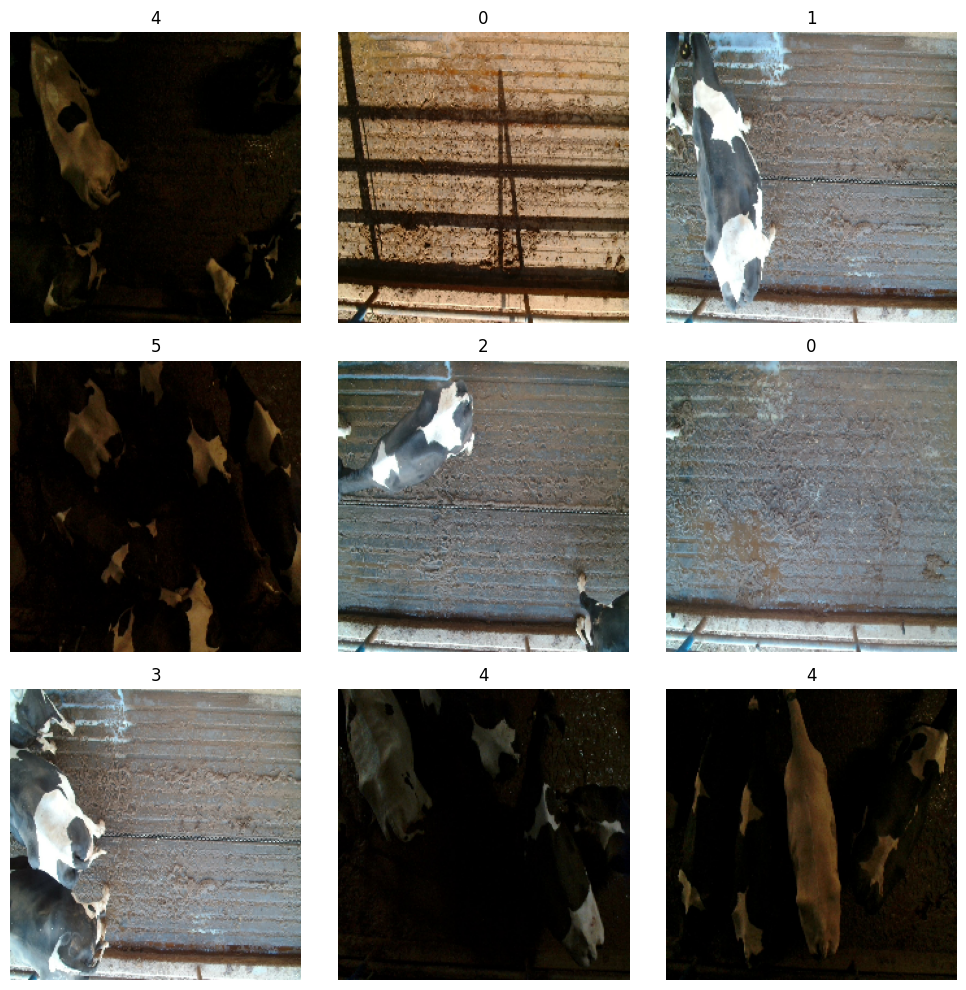

In [329]:
show_batch(train_ds, class_names)

Analyzing class distribution: 100%|██████████| 21/21 [00:00<00:00, 122.52it/s]


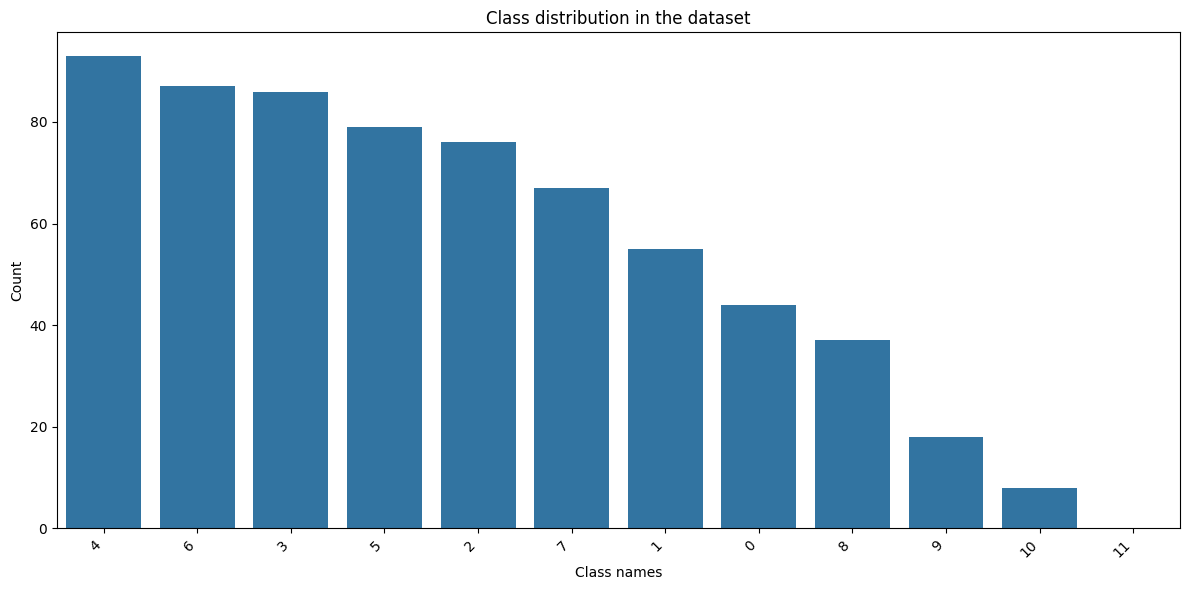

In [330]:
analyze_class_distribution(train_ds, class_names)

/home/carlos/miniconda3/envs/tf/lib/python3.11/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


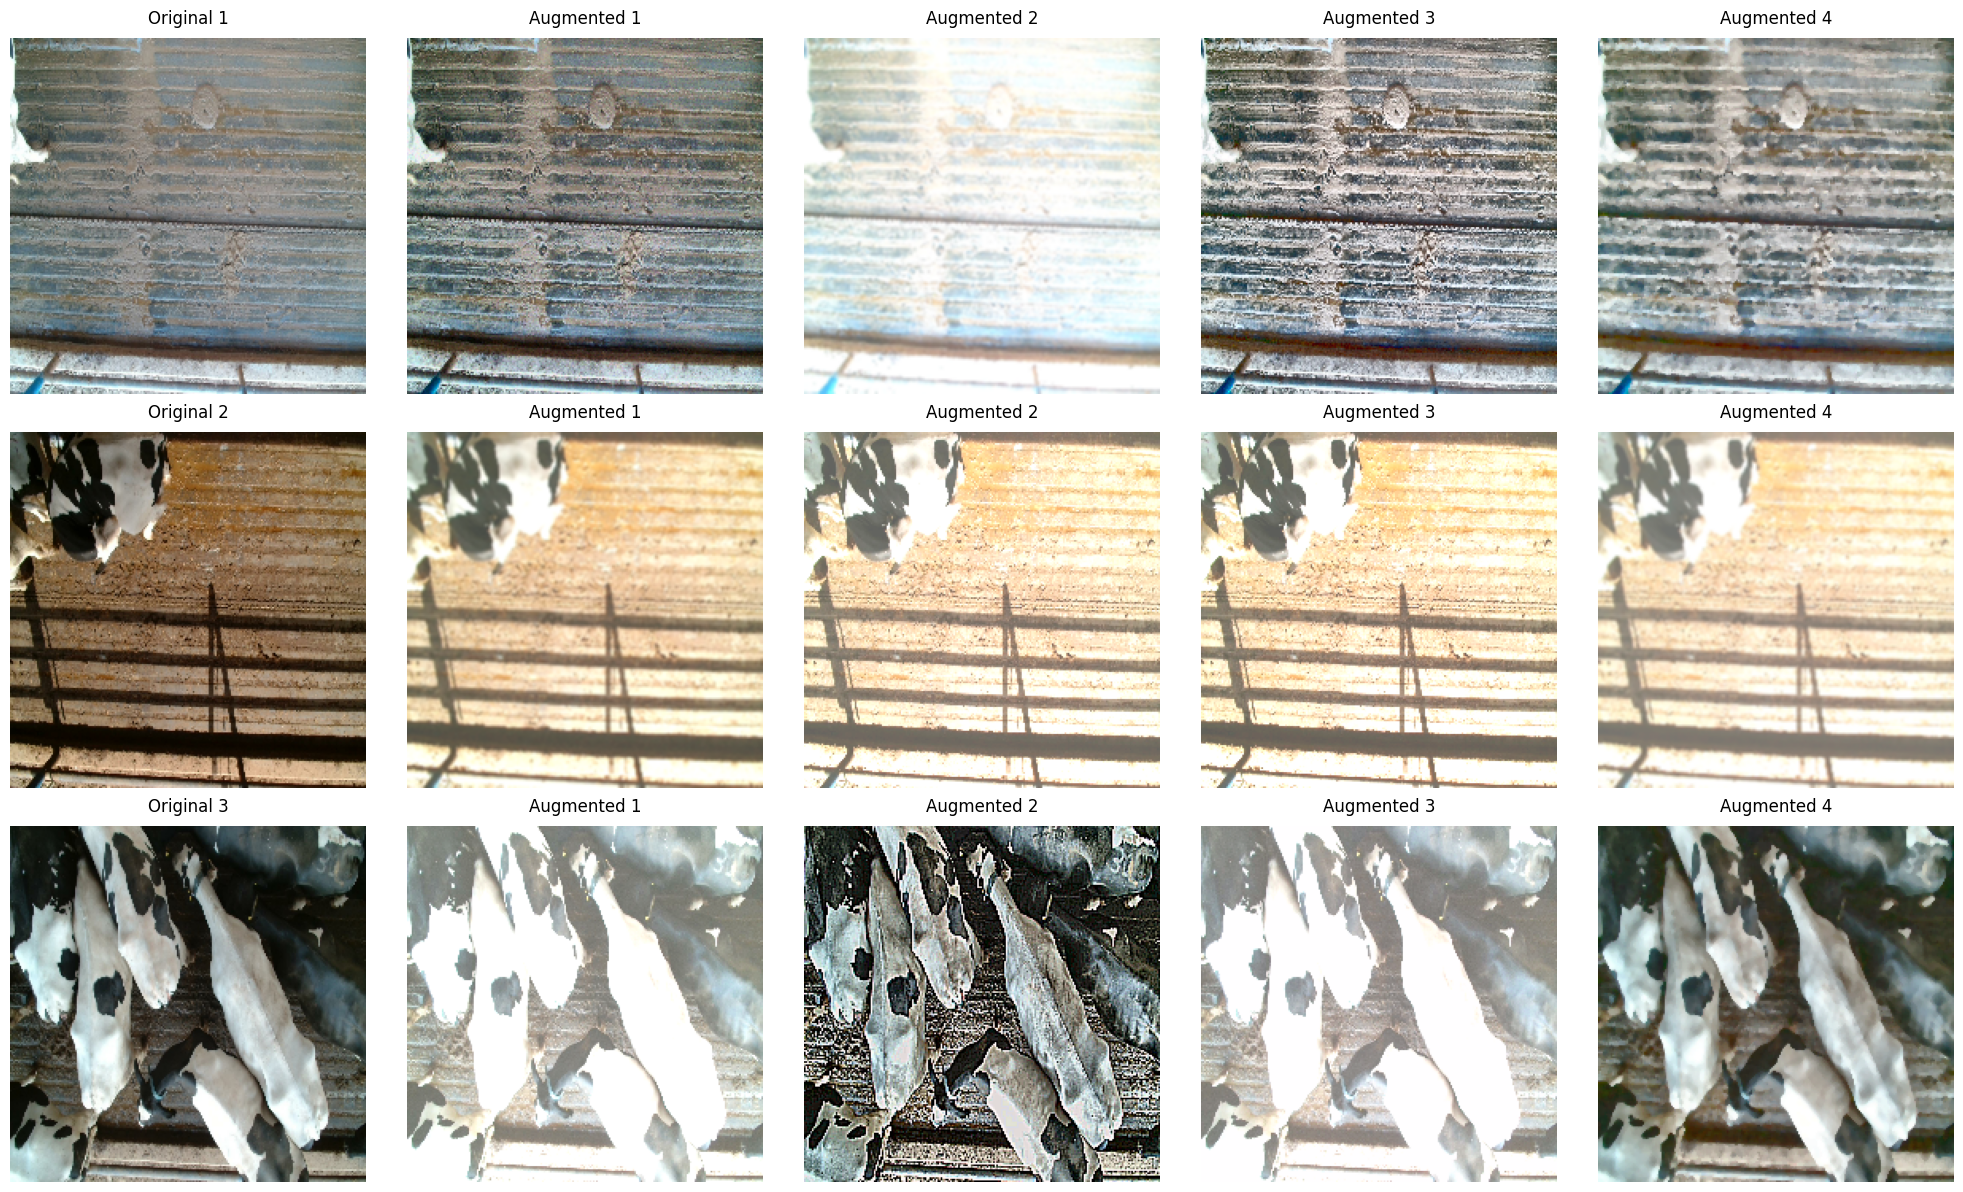

In [331]:
data_augmentation = DataAugmentation(IMG_SIZE)
visualize_data_augmentation(
  dataset=train_ds,
  data_augmentation=data_augmentation,
  num_images=3,
  num_augmentations=4,
)

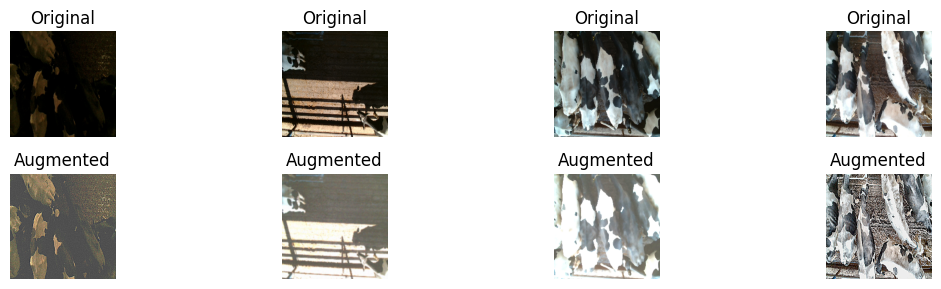

In [332]:
visualize_augmentation_comparison(
  dataset=train_ds,
  data_augmentation=data_augmentation,
  num_pairs=4,
)

### Creating the base model


In [333]:
model = create_classification_model(
    img_size=IMG_SIZE,
    num_classes=len(class_names),
)

In [334]:
compile_model(model)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation_23            │ (None, 224, 224, 3)    │             0 │
│ (DataAugmentation)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply_2 (Multiply)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │         3,084 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,100,620 (91.94 MB)

 Trainable params: 6,051,084 (23.08 MB)

 Non-trainable params: 18,049,536 (68.85 MB)

In [335]:
visualize_model_architecture(model, name="first_iteration")

Model architecture visualization saved to base_model_architecture.png


In [336]:
callbacks, model_dir = create_callback(
    experiment_name="night_cattle_classification", patience=10
)

In [339]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7427 - loss: 5.0794
Epoch 1: val_accuracy did not improve from 0.07407

Epoch 1: saving model to models/night_cattle_classification_20241022-102157/checkpoints/latest_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7410 - loss: 5.0824 - val_accuracy: 0.0741 - val_loss: 354.1963 - learning_rate: 1.0000e-05
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7018 - loss: 5.0772
Epoch 2: val_accuracy improved from 0.07407 to 0.08642, saving model to models/night_cattle_classification_20241022-102157/checkpoints/best_model.keras

Epoch 2: saving model to models/night_cattle_classification_20241022-102157/checkpoints/latest_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7018 - loss: 5.0782 - val_accuracy: 0.0864 - val_loss: 360.2431 - learning_rate: 1.0000e-05
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7045 - loss: 5.1016
Epoch 3: val_accuracy did not improve from


Training Summary:
Best Validation Loss: 354.1963 (Epoch 1)
Best Validation Accuracy: 0.1358
Final Training Accuracy: 0.7923
Total Epochs: 20

Plot saved to: models/night_cattle_classification_20241022-102157/checkpoints/training_plot.png


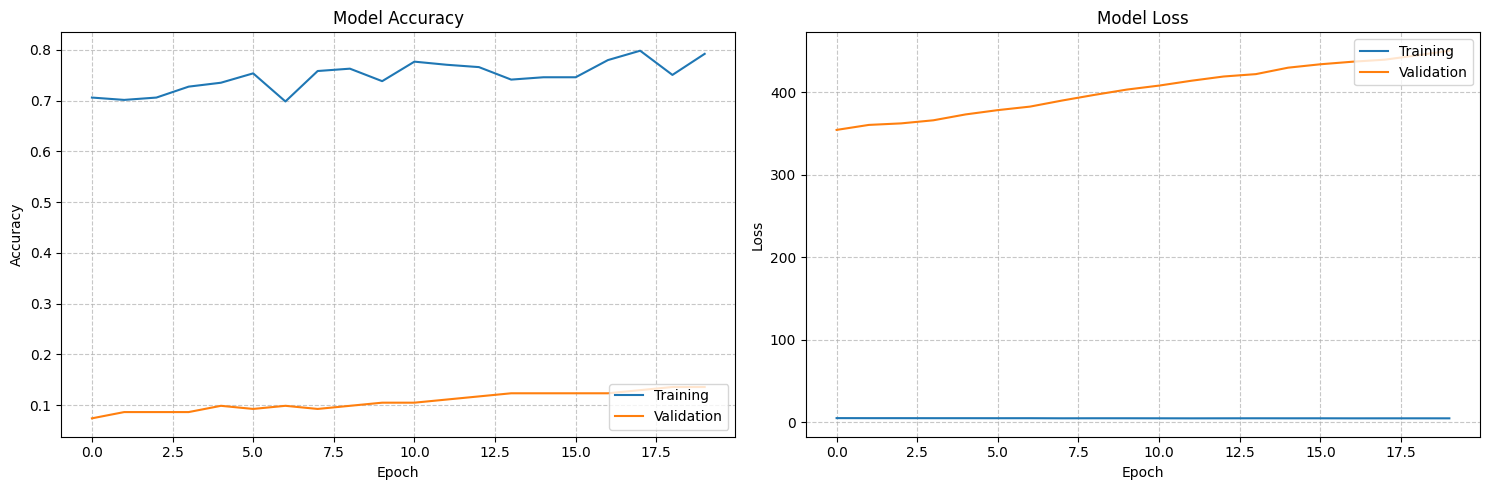

In [344]:
visualize_training_history(history, save_path=f"{model_dir}/training_plot.png")